In [1]:
%pylab inline

import numpy as np
import seaborn
from MuscleHelperFunctions import *

from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load in data from MC simulations
datapath = '../MC_data'
sarc_list = LoadData(datapath, verbose = True)

1000
2000
3000


In [3]:
# Split into training and testing sets
training_frac = 0.9
num_params = len(sarc_list.keys())

training_runs = np.random.choice(num_params, int(num_params*training_frac), replace = False)
testing_runs = [j for j in range(num_params) if j not in training_runs]

Training = [list(sarc_list.keys())[j] for j in training_runs]
Testing = [list(sarc_list.keys())[j] for j in testing_runs]

# Fit model for transition probabilities

In [4]:
N = 720
P12 = []; P11 = []; P22 = []; P21 = []; P23 = []; P33 = []; P31 = []; P32 = []
threshold = 5

for key in Training:
        
    runs = sarc_list[key]
    n = len(runs[0])
    
    state_fracs_ave = N*np.vstack([np.mean(np.vstack([np.array(run['xb_fraction_free']) for run in runs]),axis=0),
                         np.mean(np.vstack([np.array(run['xb_fraction_loose']) for run in runs]),axis=0),
                         np.mean(np.vstack([np.array(run['xb_fraction_tight']) for run in runs]),axis=0)])
    
    state_fracs_min = N*np.vstack([np.min(np.vstack([np.array(run['xb_fraction_free']) for run in runs]),axis=0),
                         np.min(np.vstack([np.array(run['xb_fraction_loose']) for run in runs]),axis=0),
                         np.min(np.vstack([np.array(run['xb_fraction_tight']) for run in runs]),axis=0)])
    
    P12_ave = np.mean(np.vstack([run['xb_trans_12']/(N*run['xb_fraction_free']) for run in runs]), axis = 0)
    P21_ave = np.mean(np.vstack([run['xb_trans_21']/(N*run['xb_fraction_loose']) for run in runs]), axis = 0)
    P23_ave = np.mean(np.vstack([run['xb_trans_23']/(N*run['xb_fraction_loose']) for run in runs]), axis = 0)
    P31_ave = np.mean(np.vstack([run['xb_trans_31']/(N*run['xb_fraction_tight']) for run in runs]), axis = 0)
    P32_ave = np.mean(np.vstack([run['xb_trans_32']/(N*run['xb_fraction_tight']) for run in runs]), axis = 0)
        
    axial_force = np.mean(np.vstack([run['axial_force'] for run in runs]), axis = 0)
    radial_tension = np.mean(np.vstack([run['radial_tension'] for run in runs]), axis = 0)
        
    # Loop over timesteps
    for j in range(1,n):
        
        # External forcing
        perm = runs[0]['actin_permissiveness'][j]
        zt = runs[0]['z_line'][j] - runs[0]['z_line'][j-1]
        z = runs[0]['z_line'][j] - np.mean(runs[0]['z_line'])
                    
        # Only look at ones where we can get transition probabilities
        if state_fracs_ave[0,j] >= threshold and state_fracs_min[0,j] > 0:
            P12.append([perm, zt, z, radial_tension[j], P12_ave[j]])

        if state_fracs_ave[1,j] >= threshold and state_fracs_min[1,j] > 0:
            P21.append([perm, zt, z, radial_tension[j], P21_ave[j]])
            P23.append([perm, zt, z, radial_tension[j], P23_ave[j]])

        if state_fracs_ave[2,j] >= threshold and state_fracs_min[2,j] > 0:
            P31.append([perm, zt, z, radial_tension[j], P31_ave[j]])
            P32.append([perm, zt, z, radial_tension[j], P32_ave[j]])

In [5]:
P = {}
P[(1,2)] = P12
P[(2,1)] = P21
P[(2,3)] = P23
P[(3,2)] = P32
P[(3,1)] = P31
Xi = {}

trans_prob_deg = 3

for key, Pr in P.items():
    
    n = len(Pr)
    
    poly = PolynomialFeatures(degree=trans_prob_deg)
    X = poly.fit_transform(np.vstack([np.array(j[:-1]) for j in Pr]))
    PP = np.vstack([j[-1] for j in Pr])
    Xi[key] = LassoCV(cv=10, n_jobs=-1, max_iter=25000, normalize = True).fit(X,PP.flatten())

    print(key)

(1, 2)
(2, 1)
(2, 3)
(3, 2)
(3, 1)


# Fit model for axial force and radial tension

In [6]:
dt = 0.05
data =[]

for key in Training:
    
    runs = sarc_list[key]
        
    # Get forcing info from previous step
    axial_force = np.mean(np.vstack([run['axial_force'] for run in runs]), axis = 0)
    radial_tension = np.mean(np.vstack([run['radial_tension'] for run in runs]), axis = 0)
        
    # Get avaliable info from current step
    z = np.array(runs[0]['z_line'][1:])
    ls = np.array(runs[0]['lattice_spacing'][1:])
    actin = np.array(runs[0]['actin_permissiveness'][1:])
    zt = np.array(runs[0]['z_line'][1:])-np.array(runs[0]['z_line'][:-1])
    fraction_free = np.mean(np.vstack([run['xb_fraction_free'][1:] for run in runs]), axis = 0)
    fraction_loose = np.mean(np.vstack([run['xb_fraction_loose'][1:] for run in runs]), axis = 0)
    fraction_tight = np.mean(np.vstack([run['xb_fraction_tight'][1:] for run in runs]), axis = 0)
    
    # Combine everything into matrix
    X = np.hstack([col.reshape(4399,1) for col in [z-np.mean(z),(z-np.mean(z)).clip(0), zt, ls, \
                                                  fraction_loose, fraction_tight]])
    force = np.hstack([axial_force[1:].reshape(4399,1), \
                       radial_tension[1:].reshape(4399,1)])
    
    data.append([X, force])
    
X = np.vstack([dataset[0] for dataset in data])
y = np.vstack([dataset[1] for dataset in data])

In [7]:
force_deg = 2
X2 = PolynomialFeatures(degree=force_deg).fit_transform(X)

axial_predictor = RidgeCV(cv=5).fit(X2,y[:,0])
radial_predictor = RidgeCV(cv=5).fit(X2,y[:,1])

# axial_predictor = GradientBoostingRegressor(n_estimators=100,max_depth=3).fit(X2,y[:,0])
# radial_predictor = GradientBoostingRegressor(n_estimators=100,max_depth=3).fit(X2,y[:,1])

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.36327e-18): result may not be accurate.
  overwrite_a=True).T
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.36327e-18): result may not be accurate.
  overwrite_a=True).T
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.36327e-18): result may not be accurate.
  overwrite_a=True).T
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.36327e-18): result may not be accurate.
  overwrite_a=True).T
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.36327e-17): result may not be accurate.
  overwrite_a=True).T
/home/samuel/anaconda3/li

# Test on novel input

In [8]:
###########################################
regime = Testing[0]
###########################################

runs = sarc_list[regime]
z = np.array(sarc_list[regime][0]['z_line'])[1:]
ls = np.array(runs[0]['lattice_spacing'][1:])
lst = np.array(runs[0]['lattice_spacing'][1:]) - np.array(runs[0]['lattice_spacing'][:-1])
zt = np.array(sarc_list[regime][0]['z_line'])[1:]-np.array(sarc_list[regime][0]['z_line'])[:-1]
axial_force = np.mean(np.vstack([run['axial_force'] for run in runs]), axis = 0)
axial_force_dev = np.std(np.vstack([run['axial_force'] for run in runs]), axis = 0)
radial_tension = np.mean(np.vstack([run['radial_tension'] for run in runs]), axis = 0)
radial_tension_dev = np.std(np.vstack([run['radial_tension'] for run in runs]), axis = 0)
p = np.array(sarc_list[regime][0]['actin_permissiveness'])[1:]
N = len(z)

###########################################
#
# Get true values relating to transition probabilities and fractions in each state
#
###########################################

Num_bridges = 720
P12_true = np.nanmean(np.vstack([run['xb_trans_12']/(Num_bridges*run['xb_fraction_free']) for run in runs]), axis = 0)
P21_true = np.nanmean(np.vstack([run['xb_trans_21']/(Num_bridges*run['xb_fraction_loose']) for run in runs]), axis = 0)
P23_true = np.nanmean(np.vstack([run['xb_trans_23']/(Num_bridges*run['xb_fraction_loose']) for run in runs]), axis = 0)
P31_true = np.nanmean(np.vstack([run['xb_trans_31']/(Num_bridges*run['xb_fraction_tight']) for run in runs]), axis = 0)
P32_true = np.nanmean(np.vstack([run['xb_trans_32']/(Num_bridges*run['xb_fraction_tight']) for run in runs]), axis = 0)

P11_true = 1 - P12_true
P22_true = 1 - P21_true - P23_true
P33_true = 1 - P32_true - P31_true
w = 15
P12_smooth = MovingAve(P12_true, w)
P21_smooth = MovingAve(P21_true, w)
P23_smooth = MovingAve(P23_true, w)
P32_smooth = MovingAve(P32_true, w)
P31_smooth = MovingAve(P31_true, w)
P11_smooth = MovingAve(P11_true, w)
P22_smooth = MovingAve(P22_true, w)
P33_smooth = MovingAve(P33_true, w)

P11_model = np.zeros(N-1); P12_model = np.zeros(N-1); P21_model = np.zeros(N-1); P22_model = np.zeros(N-1);
P23_model = np.zeros(N-1); P31_model = np.zeros(N-1); P32_model = np.zeros(N-1); P33_model = np.zeros(N-1);

state_fracs = np.vstack([np.mean(np.vstack([run[item][1:] for run in runs]), axis = 0) for item \
                         in ['xb_fraction_free','xb_fraction_loose','xb_fraction_tight']])
state_fracs_dev = np.vstack([np.std(np.vstack([run[item][1:] for run in runs]), axis = 0) for item \
                         in ['xb_fraction_free','xb_fraction_loose','xb_fraction_tight']])

###########################################
#
# Loop through time to get model prediction
#
###########################################

# Initialize state fractions and forcing
S = np.zeros((3,N))
S[:,0] = state_fracs[:,0]

F = np.zeros((2,N))
F[0,0] = axial_force[0]
F[1,0] = radial_tension[0]

for j in range(N-1):
    
    zm = z[j]-np.mean(z) # mean subtracted
    zc = zm.clip(0) # positive component
    lsm =  ls[j]-np.mean(ls)
    
    X_trans = PolynomialFeatures(degree=trans_prob_deg).fit_transform((np.array([p[j], zt[j], zm,\
                                                                                 F[1,j]])).reshape(1, -1))
    
    P12_model[j] = Xi[(1,2)].predict(X_trans).clip(0,1)
    P21_model[j] = Xi[(2,1)].predict(X_trans).clip(0,1)
    P23_model[j] = Xi[(2,3)].predict(X_trans).clip(0,1)
    P31_model[j] = Xi[(3,1)].predict(X_trans).clip(0,1)
    P32_model[j] = Xi[(3,2)].predict(X_trans).clip(0,1)
    
    P11_model[j] = 1 - P12_model[j]
    P22_model[j] = 1 - P21_model[j] - P23_model[j]
    P33_model[j] = 1 - P31_model[j] - P32_model[j]
    
    TP = np.vstack([np.hstack([P11_model[j], P21_model[j], P31_model[j]]),
           np.hstack([P12_model[j], P22_model[j], P32_model[j]]),
           np.hstack([0, P23_model[j], P33_model[j]])])
    
    # Update fraction in each state
    S[:,j+1] = TP.dot(S[:,j])
    
    # Compute new forcing
    X_force = PolynomialFeatures(degree=force_deg).fit_transform(np.array([zm, zc, zt[j+1], ls[j+1], \
                                         S[1,j+1], S[2,j+1]]).reshape(1, -1))

    F[0,j+1] = axial_predictor.predict(X_force)
    F[1,j+1] = radial_predictor.predict(X_force)

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


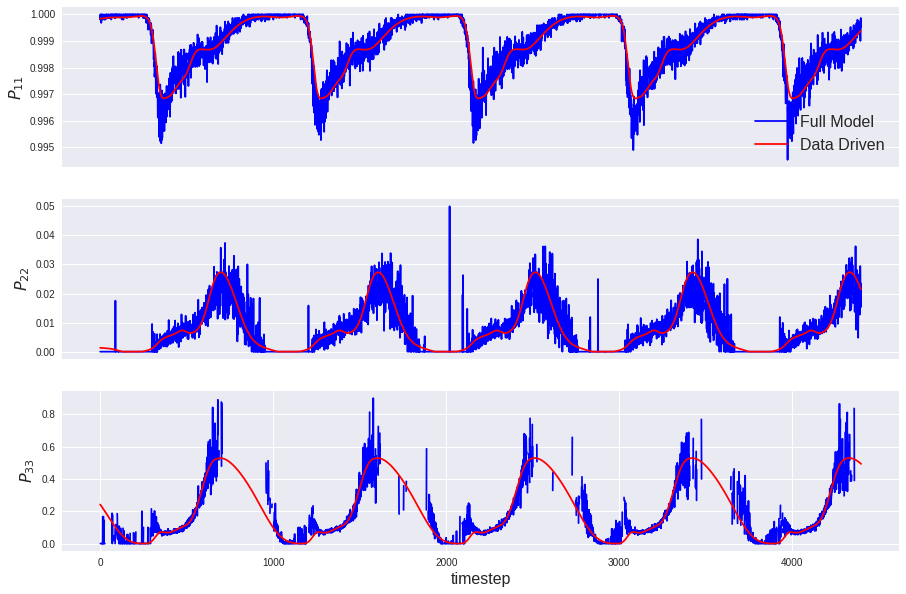

In [9]:
figure(figsize = (15,10))

label_font_size = 16

subplot(3,1,1)
plot(P11_true, 'b', label = 'Full Model')
plot(P11_model, 'r', label = 'Data Driven')
xticks([])
ylabel(r'$P_{11}$', fontsize = label_font_size)
legend(fontsize = label_font_size)

subplot(3,1,2)
plot(P21_true, 'b')
plot(P21_model, 'r')
xticks([])
ylabel(r'$P_{22}$', fontsize = label_font_size)

subplot(3,1,3)
plot(P32_true, 'b')
plot(P32_model, 'r')
ylabel(r'$P_{33}$', fontsize = label_font_size)
xlabel(r'timestep', fontsize = label_font_size)

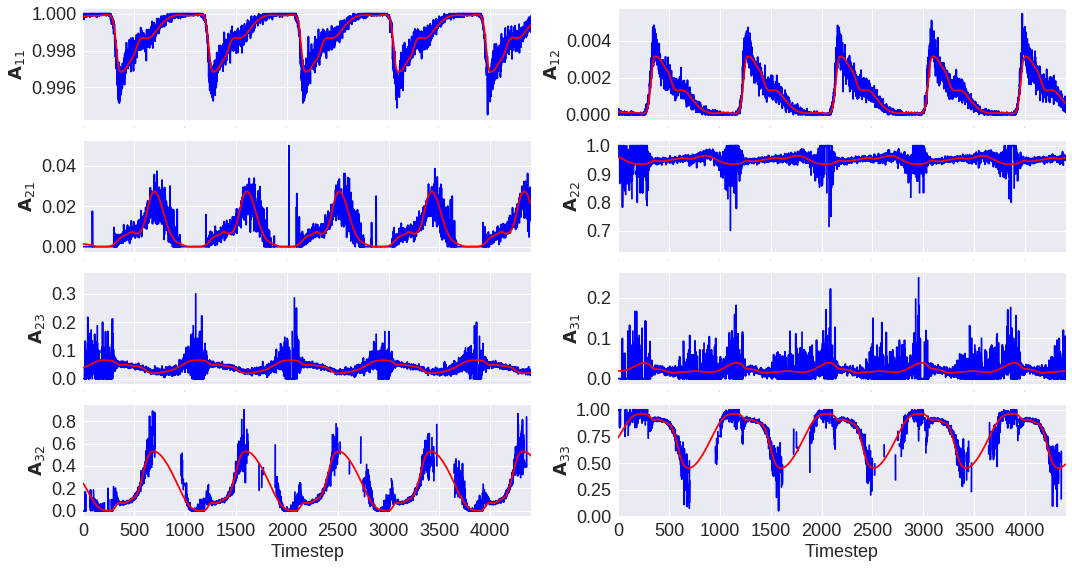

In [10]:
figure(figsize = (15,8))

label_font_size = 18

true_trans_probs = [P11_true, P12_true, P21_true, P22_true, P23_true, P31_true, P32_true, P33_true]
model_trans_probs = [P11_model, P12_model, P21_model, P22_model, P23_model, P31_model, P32_model, P33_model]
trans_prob_labels = [r'$\mathbf{A}_{11}$', r'$\mathbf{A}_{12}$', r'$\mathbf{A}_{21}$', r'$\mathbf{A}_{22}$', \
                     r'$\mathbf{A}_{23}$', r'$\mathbf{A}_{31}$', r'$\mathbf{A}_{32}$', r'$\mathbf{A}_{33}$']

for j in range(8):
    subplot(4,2,j+1)
    plot(true_trans_probs[j], 'b', label = 'Full Model')
    plot(model_trans_probs[j], 'r', label = 'Data Driven')
    yticks(fontsize = label_font_size)
    ylabel(trans_prob_labels[j], fontsize = label_font_size)
    xlim([0,4400])
    
    if j > 5: 
        xticks(fontsize = label_font_size)
        xlabel('Timestep', fontsize = label_font_size)
    else:
        xticks(fontsize = 0)

tight_layout()

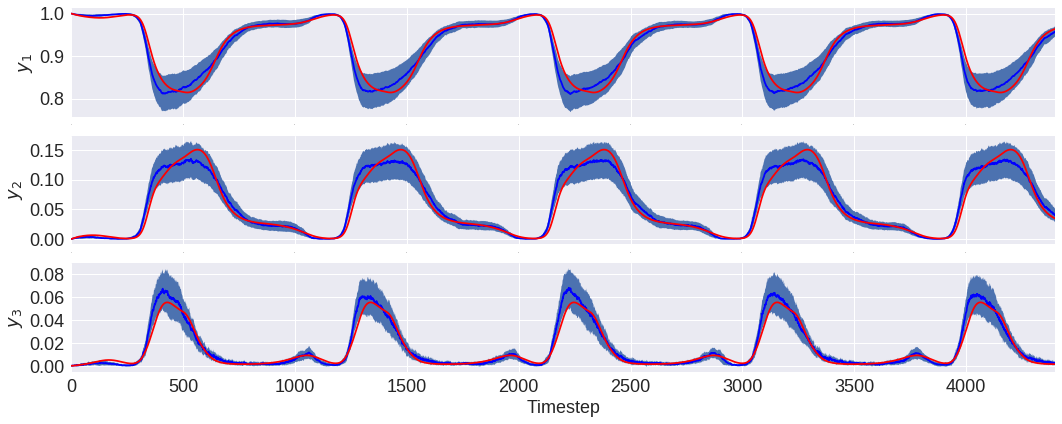

In [11]:
figure(figsize = (15,6))

label_font_size = 18

subplot(3,1,1)
plot(state_fracs[0,:], 'b', label = 'Full Model')
plot(S[0,:], 'r', label = 'Data Driven')
fill_between(np.arange(4399),state_fracs[0,:]+state_fracs_dev[0,:], state_fracs[0,:]-state_fracs_dev[0,:])
xticks(fontsize = 0)
yticks(fontsize = label_font_size)
ylabel(r'$y_1$', fontsize = label_font_size)
xlim([0,4400])

subplot(3,1,2)
plot(state_fracs[1,:], 'b')
plot(S[1,:], 'r')
fill_between(np.arange(4399),state_fracs[1,:]+state_fracs_dev[1,:], state_fracs[1,:]-state_fracs_dev[1,:])
xticks(fontsize = 0)
yticks(fontsize = label_font_size)
ylabel(r'$y_2$', fontsize = label_font_size)
xlim([0,4400])

subplot(3,1,3)
plot(state_fracs[2,:], 'b', label = 'Full Simulation')
plot(S[2,:], 'r', label = 'Data Driven')
fill_between(np.arange(4399),state_fracs[2,:]+state_fracs_dev[2,:], state_fracs[2,:]-state_fracs_dev[2,:])
ylabel(r'$y_3$', fontsize = label_font_size)
xlabel('Timestep', fontsize = label_font_size)
xlim([0,4400])
yticks(fontsize = label_font_size)
xticks(fontsize = label_font_size)

tight_layout()

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 <a list of 7 Text yticklabel objects>)

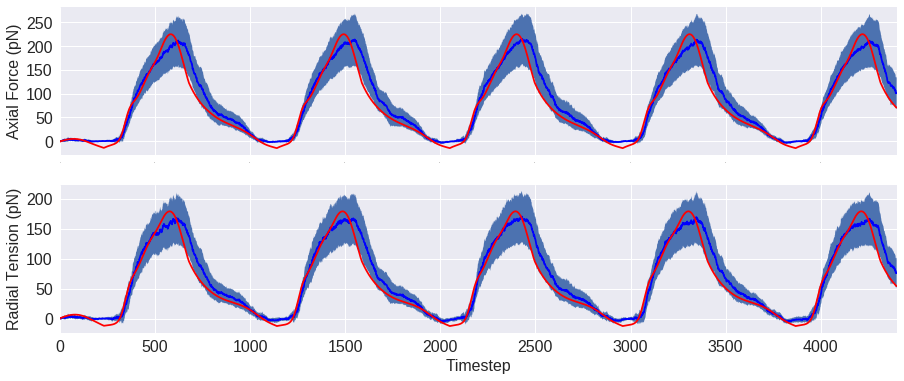

In [12]:
figure(figsize = (15,6))

label_font_size = 16

subplot(2,1,1)
plot(axial_force, 'b', label = 'Full Model')
plot(F[0,:], 'r', label = 'Data Driven')
fill_between(np.arange(4400),axial_force+axial_force_dev, axial_force-axial_force_dev)
xticks(fontsize = 0)
ylabel('Axial Force (pN)', fontsize = label_font_size)
xlim([0,4400])
yticks(fontsize = label_font_size)

subplot(2,1,2)
plot(radial_tension, 'b')
plot(F[1,:], 'r')
fill_between(np.arange(4400),radial_tension+radial_tension_dev, radial_tension-radial_tension_dev)
ylabel('Radial Tension (pN)', fontsize = label_font_size)
xlabel('Timestep', fontsize = label_font_size)
xlim([0,4400])
xticks(fontsize = label_font_size)
yticks(fontsize = label_font_size)

# Compute workloops for all regimes

In [13]:
# Get workloops for all regimes
model = {}
count = 0

for regime in sarc_list.keys():
    
    print('\r', count, end = '')
    
    runs = sarc_list[regime]
    z = np.array(sarc_list[regime][0]['z_line'])[1:]
    ls = np.array(runs[0]['lattice_spacing'][1:])
    lst = np.array(runs[0]['lattice_spacing'][1:]) - np.array(runs[0]['lattice_spacing'][:-1])
    zt = np.array(sarc_list[regime][0]['z_line'])[1:]-np.array(sarc_list[regime][0]['z_line'])[:-1]
    axial_force = np.mean(np.vstack([run['axial_force'] for run in runs]), axis = 0)
    radial_tension = np.mean(np.vstack([run['radial_tension'] for run in runs]), axis = 0)
    p = np.array(sarc_list[regime][0]['actin_permissiveness'])[1:]
    N = len(z)

    ###########################################
    #
    # Get true values relating to transition probabilities and fractions in each state
    #
    ###########################################

    Num_bridges = 720
    P12_true = np.mean(np.vstack([run['xb_trans_12']/(Num_bridges*run['xb_fraction_free']) for run in runs]), axis = 0)
    P21_true = np.mean(np.vstack([run['xb_trans_21']/(Num_bridges*run['xb_fraction_loose']) for run in runs]), axis = 0)
    P23_true = np.mean(np.vstack([run['xb_trans_23']/(Num_bridges*run['xb_fraction_loose']) for run in runs]), axis = 0)
    P31_true = np.mean(np.vstack([run['xb_trans_31']/(Num_bridges*run['xb_fraction_tight']) for run in runs]), axis = 0)
    P32_true = np.mean(np.vstack([run['xb_trans_32']/(Num_bridges*run['xb_fraction_tight']) for run in runs]), axis = 0)
    P11_true = 1 - P12_true
    P22_true = 1 - P21_true - P23_true
    P33_true = 1 - P32_true - P31_true
    w = 15
    P12_smooth = MovingAve(P12_true, w)
    P21_smooth = MovingAve(P21_true, w)
    P23_smooth = MovingAve(P23_true, w)
    P32_smooth = MovingAve(P32_true, w)
    P31_smooth = MovingAve(P31_true, w)
    P11_smooth = MovingAve(P11_true, w)
    P22_smooth = MovingAve(P22_true, w)
    P33_smooth = MovingAve(P33_true, w)

    P11_model = np.zeros(N-1); P12_model = np.zeros(N-1); P21_model = np.zeros(N-1); P22_model = np.zeros(N-1);
    P23_model = np.zeros(N-1); P31_model = np.zeros(N-1); P32_model = np.zeros(N-1); P33_model = np.zeros(N-1);

    state_fracs = np.vstack([np.mean(np.vstack([run[item][1:] for run in runs]), axis = 0) for item \
                             in ['xb_fraction_free','xb_fraction_loose','xb_fraction_tight']])

    ###########################################
    #
    # Loop through time to get model prediction
    #
    ###########################################

    # Initialize state fractions and forcing
    S = np.zeros((3,N))
    S[:,0] = state_fracs[:,0]

    F = np.zeros((2,N+1))
    F[0,0] = axial_force[0]
    F[1,0] = radial_tension[0]

    for j in range(N-1):

        zm = z[j]-np.mean(z) # mean subtracted
        zc = zm.clip(0) # clipped
        lsm = ls[j]-np.mean(ls)
        X_trans = PolynomialFeatures(degree=trans_prob_deg).fit_transform((np.array([p[j], zt[j], zm, \
                                                                                 F[1,j]])).reshape(1, -1))
    
        P12_model[j] = Xi[(1,2)].predict(X_trans).clip(0,1)
        P21_model[j] = Xi[(2,1)].predict(X_trans).clip(0,1)
        P23_model[j] = Xi[(2,3)].predict(X_trans).clip(0,1)
        P31_model[j] = Xi[(3,1)].predict(X_trans).clip(0,1)
        P32_model[j] = Xi[(3,2)].predict(X_trans).clip(0,1)

        P11_model[j] = 1 - P12_model[j]
        P22_model[j] = 1 - P21_model[j] - P23_model[j]
        P33_model[j] = 1 - P31_model[j] - P32_model[j]

        TP = np.vstack([np.hstack([P11_model[j], P21_model[j], P31_model[j]]),
               np.hstack([P12_model[j], P22_model[j], P32_model[j]]),
               np.hstack([0, P23_model[j], P33_model[j]])])

        # Update fraction in each state
        S[:,j+1] = TP.dot(S[:,j])

        # Compute new forcing
        X_force = PolynomialFeatures(degree=force_deg).fit_transform(np.array([zm, zc, zt[j+1], ls[j+1], \
                                         S[1,j+1], S[2,j+1]]).reshape(1, -1))
    
        F[0,j+1] = axial_predictor.predict(X_force)
        F[1,j+1] = radial_predictor.predict(X_force)

    model[regime] = F
    
    count = count + 1

 149

In [ ]:
work = {}
dt = 0.05

count = 0

for j in range(len(list(sarc_list.keys()))):
    
    print('\r', count, end = '')

    regime = list(sarc_list.keys())[j]
    period = int(regime[0]/dt)
    
    z = np.array(sarc_list[regime][0]['z_line'])
    axial = np.mean(np.vstack(run['axial_force'] for run in sarc_list[regime]), axis = 0)
    axial_model = model[regime][0,:]

    # Get work per loop and record
    beta = 3
    start = 114 # so that we have exactly three periods
    end = start + beta*period
    
    work_true = sum([-(z[i]-z[i-1])*axial[i] for i in range(start, end)]) / beta
    work_model = sum([-(z[i]-z[i-1])*axial_model[i] for i in range(start, end)]) / beta
    work_std_dev = np.std([sum([(z[i]-z[i-1])*run['axial_force'][i] for i in range(start, end)]) \
                           for run in sarc_list[regime]]) / beta   
    work[regime] = [work_true, work_model, work_std_dev]
        
    count = count +1

 0

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


 145

In [ ]:
figure(figsize = (15,9))
dt = 0.05

label_fontsize = 16
count = 0

for regime in Testing:
    
    period = int(regime[0]/dt)
    
    z = np.array(sarc_list[regime][0]['z_line'])
    axial = np.mean(np.vstack(run['axial_force'] for run in sarc_list[regime]), axis = 0)
    axial_model = model[regime][0,:]
    
    subplot(3,5,count+1)

    scatter(z,axial, color = 'b', s = 10)
    scatter(z,axial_model, color = 'r', s = 10)

    if count == 10:
        xlabel(r'Length (nm)', fontsize = label_fontsize)
        ylabel('Force (pN)', fontsize = label_fontsize)
    
    count = count +1
    
    xticks(fontsize = label_fontsize)
    yticks(fontsize = label_fontsize)
    
tight_layout()

In [ ]:
figure(figsize = (10,10))

label_fontsize = 18

ww = np.linspace(-80000,20000,2)
plot(ww,ww, color = 'k', linewidth = 1)
xlim([-6,2])
ylim([-6,2])

errorbar([work[key][0]/1000 for key in Training], [work[key][1]/1000 for key in Training], \
         xerr=[work[key][2]/1000 for key in Training], color = 'b', fmt='o', ecolor='b', capthick=1, \
         label =  'Training Data')

errorbar([work[key][0]/1000 for key in Testing], [work[key][1]/1000 for key in Testing], \
         xerr=[work[key][2]/1000 for key in Testing], color = 'r', fmt='o', ecolor='r', capthick=2, \
         label =  'Testing Data', zorder = 1000)

label_fontsize = 18
xlabel(r'Work from Monte Carlo Model ($J\cdot10^{-18}$)', fontsize = label_fontsize)
ylabel(r'Work from Data Driven Model ($J\cdot10^{-18}$)', fontsize = label_fontsize)

xticks(fontsize = 18)
yticks(fontsize = 18)